In [39]:
from pyrdf2vec.graphs import KG
import rdflib
import random 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from collections import Counter

# 1. Get the entitites and corresponding classes

In [3]:
data = "aifb"
if data == "aifb":
    kg = KG(location="../data/aifbfixed_complete.n3", file_type="n3")
elif data == "bgs":
    kg = KG(location="../data/bgs.nt", file_type="nt")
elif data== "mutag":
    kg = KG(location="../data/mutag.xml", file_type="xml")

g = rdflib.Graph()
if data == "aifb":
    g.parse("../data/aifbfixed_complete.n3", format="n3")
elif data == "bgs":
    g.parse("../data/bgs.nt", format="nt")
elif data == "mutag":
    g.parse("../data/mutag.xml", format="xml")

q = g.query("""SELECT ?entity ?type
            WHERE {
              ?entity rdf:type ?type.
            }""")
entities = []
classes = []
for row in q:
    entities.append(row[0])
    classes.append(row[1])

In [4]:
set(classes)

{rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Article'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#AssistantProfessor'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Book'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#FullProfessor'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Graduate'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#InCollection'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#InProceedings'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Lecturer'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Manager'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Misc'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Organization'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Person'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#PhDStudent'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Proceedings'),
 rdflib.term.URIRef('http://swrc.ontoware

# 2. Filtering

In [5]:
filtered_index = []
index = 0
for e in entities:
    if e in kg._entities:
        filtered_index.append(index)
    index += 1
    
entities_filt = [entities[i] for i in filtered_index]
classes_filt = [classes[i] for i in filtered_index]

entities = entities_filt

Each class is a string like "http://swrc.ontoware.org/ontology#TechnicalStaff". We do some preprocessing to obtain a more natural presentation (by deleting the leading characters).

In [6]:
def get_classes(data):
    classes = []
    for class_type in classes_filt:
        if data == "mutag":
            class_type = class_type.lstrip("http://dl-learner.org/carcinogenesis#")
            class_type = class_type.lstrip("www.w3.org/2002/07/owl#")
        else:
            class_type = class_type.lstrip("http://swrc.ontoware.org/ontology#")
            class_type = class_type.lstrip("3.org/2002/07/owl#")
        classes.append(class_type)
    return np.array(classes)

Finally, each entity is one of the following set of classes:

In [7]:
print(Counter(get_classes(data)))

Counter({'Publication': 1222, 'Person': 1045, 'InProceedings': 687, 'TechnicalReport': 169, 'Article': 161, 'ResearchTopic': 146, 'InCollection': 87, 'Project': 78, 'PhDStudent': 65, 'Class': 55, 'Misc': 51, 'Proceedings': 49, 'ObjectProperty': 42, 'DatatypeProperty': 31, 'Organization': 28, 'Book': 23, 'Lecturer': 6, 'Undergraduate': 6, 'FullProfessor': 5, 'ResearchGroup': 5, 'TechnicalStaff': 3, 'AssistantProfessor': 3, 'Graduate': 2, 'Ontology': 1, 'Datatype': 1, 'Manager': 1})


In [8]:
def select_classes(data):
    if data == "aifb":
        return(["Publication", "Person", "InProceedings"])
    elif data == "mutag":
        return(["Hydrogen-3", "Bond-1", "Bond-7", "Carbon-22", "Carbon-10"])
    
def select_data(X, data):
    classes = get_classes(data)
    selected_classes = select_classes(data) # get the most prominent classes
    indexes = []
    for j in range(len(classes)):
        if classes[j] in selected_classes:
            indexes.append(j)
    X = X[indexes]
    y = classes[indexes]
    return(X, y)

# 3. Import the embeddings

In [200]:
nlp_model = "cbow" # skip-gram or cbow
num_embeddings = 10
embeddings = []

dim_red = "tsne2d" # "pca2d", "pca3d", "tsne2d", or "tsne3d"

# read embeddings:
for iter in range(num_embeddings):
    embeddings.append(np.load("embeddings/" + data + "/" + nlp_model + "/" + dim_red + "/embedding" + str(iter) + ".npy"))

# 4. k-NN classifier

In [201]:
X, y = select_data(embeddings[0], data)

In [202]:
for class_type in set(y):
    print(class_type)
    print(len(X[np.where(y==class_type)]))

Carbon-10
1162
Hydrogen-3
3632
Bond-1
6781
Carbon-22
1841
Bond-7
2067


Note: Most of these types are eiter a Person, or a Publication with like 1/3 vs 2/3 proportion.

In [203]:
X_cp = X.copy()
scaler = StandardScaler()
X_cp_scaled = scaler.fit_transform(X_cp)

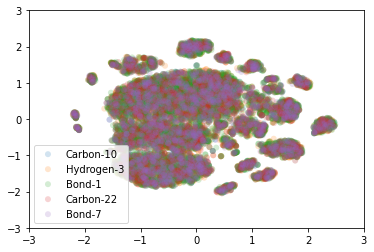

In [204]:
fig, ax = plt.subplots()
#color = 
for class_type in set(y):
    index = np.where(y==class_type)
    ax.scatter(X_cp_scaled[index, 0], X_cp_scaled[index,1], label=class_type,
               alpha=0.2, edgecolors='none')
ax.legend()
ax.set_ylim([-3, 3])
ax.set_xlim([-3,3])
plt.show()

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [206]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

n_neighbors = 20
clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [207]:
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
y_pred = clf.predict(X_test)

In [208]:
f'The accuracy is now: {np.round(sum(y_pred == y_test)/len(y_pred), 2)} %'

'The accuracy is now: 0.41 %'

In [209]:
def compare_pred(data, dim_red, nlp_model):
    num_embeddings = 10
    embeddings = []

    # read embeddings:
    if dim_red=="":
        for iter in range(num_embeddings):
            embeddings.append(np.load("embeddings/" + data + "/" + nlp_model + "/embedding" + str(iter) + ".npy"))
    else:
        for iter in range(num_embeddings):
            embeddings.append(np.load("embeddings/" + data + "/" + nlp_model + "/" + dim_red + "/embedding" + str(iter) + ".npy"))
            
    # k-NN for each embedding    
    for j in range(num_embeddings):   
        X, y = select_data(embeddings[j], data)

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        if j==0:
            df_y = pd.DataFrame(data=y_test, columns=["truth"])
        
        
        n_neighbors = 20
        clf = neighbors.KNeighborsClassifier(n_neighbors)
        clf.fit(X_train, y_train)
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        
        y_pred = clf.predict(X_test)
        # concatenate the columns
        df_y = pd.concat([df_y, pd.DataFrame(data=y_pred, columns=["Embedding" + str(j)])], axis=1)

    # calculate the pairwise accuracy
    pw_accuracy = np.zeros((10,10))
    for j in range(num_embeddings):
        for i in range(num_embeddings):
            acc = sum( df_y["Embedding" + str(j)] == df_y["Embedding" + str(i)]) / len(df_y)  
            pw_accuracy[i, j] = np.round(acc, 2)
    pw_results = pw_accuracy[np.triu_indices(num_embeddings, k=1)]
    print(f'Results for the {data} dataset using RDF2Vec via {nlp_model} and the dimension reduction technique {dim_red}.')
    print(f'The average pairwise accuracy is {np.round(np.mean(pw_results), 2)} with a variance between pairwise accuracies of {np.round(np.var(pw_results), 2)}.')       

## Results cbow:

In [210]:
compare_pred(data, "pca2d", "cbow")

Results for the mutag dataset using RDF2Vec via cbow and the dimension reduction technique pca2d.
The average pairwise accuracy is 0.77 with a variance between pairwise accuracies of 0.0.


In [211]:
compare_pred(data, "pca3d", "cbow")

Results for the mutag dataset using RDF2Vec via cbow and the dimension reduction technique pca3d.
The average pairwise accuracy is 0.81 with a variance between pairwise accuracies of 0.0.


In [212]:
compare_pred(data, "tsne2d", "cbow")

Results for the mutag dataset using RDF2Vec via cbow and the dimension reduction technique tsne2d.
The average pairwise accuracy is 0.83 with a variance between pairwise accuracies of 0.0.


In [213]:
compare_pred(data, "tsne3d", "cbow")

Results for the mutag dataset using RDF2Vec via cbow and the dimension reduction technique tsne3d.
The average pairwise accuracy is 0.8 with a variance between pairwise accuracies of 0.0.


In [214]:
# without dimension reduction: 
compare_pred(data, "", "cbow")

Results for the mutag dataset using RDF2Vec via cbow and the dimension reduction technique .
The average pairwise accuracy is 0.88 with a variance between pairwise accuracies of 0.01.


## Results skip-gram:

In [188]:
compare_pred(data, "pca2d", "skip-gram")

Results for the aifb dataset using RDF2Vec via skip-gram and a the dimension reduction technique pca2d.
The average pairwise accuracy is 0.46 with a variance of 0.0.


In [189]:
compare_pred(data, "pca3d", "skip-gram")

Results for the aifb dataset using RDF2Vec via skip-gram and a the dimension reduction technique pca3d.
The average pairwise accuracy is 0.5 with a variance of 0.0.


In [190]:
compare_pred(data, "tsne2d", "skip-gram")

Results for the aifb dataset using RDF2Vec via skip-gram and a the dimension reduction technique tsne2d.
The average pairwise accuracy is 0.5 with a variance of 0.01.


In [191]:
compare_pred(data, "tsne3d", "skip-gram")

Results for the aifb dataset using RDF2Vec via skip-gram and a the dimension reduction technique tsne3d.
The average pairwise accuracy is 0.53 with a variance of 0.0.


## Summarize the results

In [40]:
def summary(data):
    num_embeddings = 10
    dim_red_methods = ["pca2d", "pca3d", "tsne2d", "tsne3d"]
    nlp_models = ["sg", "cbow"]

    counter = 0
    results = np.zeros(2)
    for nlp_model in ("cbow", "skip-gram"):
        for dim_red in ("pca2d", "pca3d", "tsne2d", "tsne3d"):
            embeddings = []
            # read embeddings:
            if dim_red=="":
                for iter in range(num_embeddings):
                    embeddings.append(np.load("embeddings/" + data + "/" + nlp_model + "/embedding" + str(iter) + ".npy"))
            else:
                for iter in range(num_embeddings):
                    embeddings.append(np.load("embeddings/" + data + "/" + nlp_model + "/" + dim_red + "/embedding" + str(iter) + ".npy"))

            # k-NN for each embedding    
            for j in range(num_embeddings):   
                X, y = select_data(embeddings[j], data)

                X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                if j==0:
                    df_y = pd.DataFrame(data=y_test, columns=["truth"])


                n_neighbors = 20
                clf = neighbors.KNeighborsClassifier(n_neighbors)
                clf.fit(X_train, y_train)

                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)

                y_pred = clf.predict(X_test)
                # concatenate the columns
                df_y = pd.concat([df_y, pd.DataFrame(data=y_pred, columns=["Embedding" + str(j)])], axis=1)

            # calculate the pairwise accuracy
            accuracy = np.zeros(len(y_test))
            y_same = np.zeros(len(y_test))
            for i in range(num_embeddings - 1):
                for j in range(i + 1, num_embeddings):
                    y_same += (df_y["Embedding" + str(i)] == df_y["Embedding" + str(j)])
                    
            if counter==0:
                results = pd.DataFrame({"accuracy":y_same/(num_embeddings * (num_embeddings - 1)/2), "method":np.repeat(nlp_model, len(y_same)), "dim_red": np.repeat(dim_red, len(y_same))}, columns=("accuracy", "method", "dim_red") )
            else:
                results = results.append(pd.DataFrame({"accuracy":y_same/(num_embeddings * (num_embeddings - 1)/2), "method":np.repeat(nlp_model, len(y_same)), "dim_red": np.repeat(dim_red, len(y_same))}, columns=("accuracy", "method", "dim_red") ))
            counter += 1
            
    return(results)

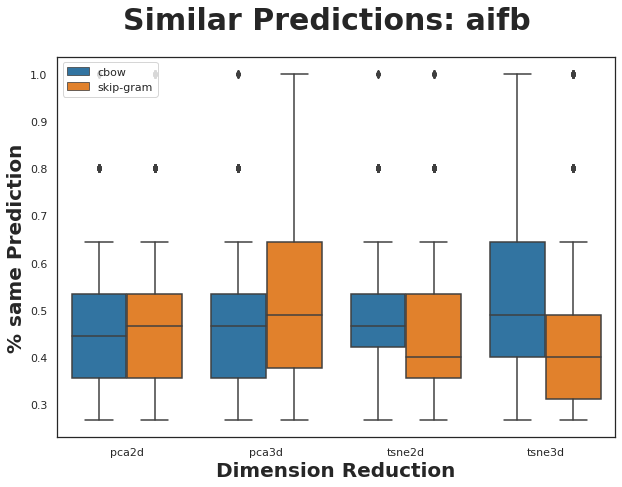

In [57]:
results = summary(data)

fig, ax = plt.subplots()
sns.set_style("white")
color = sns.color_palette("tab10")
ax = sns.boxplot(x="dim_red", y="accuracy", hue="method", data=results, palette="tab10")
#ax.set_title("Pairwise similarities: " + data, fonzsize=30)
ax.set_xlabel("Dimension Reduction", fontsize=20, weight="bold")
ax.set_ylabel("% same Prediction", fontsize=20, weight="bold")
fig.suptitle("Similar Predictions: " + data, fontsize=30, weight="bold")
plt.legend(loc='upper left')
fig.savefig("embeddings/" + data + "/boxplot_prediction.pdf")
plt.show()

In [ ]:
for j in range(num_embeddings):
                for i in range(num_embeddings):
                    acc = sum( df_y["Embedding" + str(j)] == df_y["Embedding" + str(i)]) / len(df_y)  
                    pw_accuracy[i, j] = np.round(acc, 2)
            pw_results = pw_accuracy[np.triu_indices(num_embeddings, k=1)]
            
            if i==0:
                results = pd.DataFrame({"accuracy":dist, "method":np.repeat(nlp_model, len_emb), "dim_red": np.repeat(dim_red, len_emb)}, columns=("distance", "method", "dim_red") )
            else:
                results = results.append(pd.DataFrame({"distance":dist, "method":np.repeat(nlp_model, len_emb), "dim_red": np.repeat(dim_red, len_emb)}, columns=("distance", "method", "dim_red") ))
            i += 1
            
            print(f'Results for the {data} dataset using RDF2Vec via {nlp_model} and the dimension reduction technique {dim_red}.')
            print(f'The average pairwise accuracy is {np.round(np.mean(pw_results), 2)} with a variance between pairwise accuracies of {np.round(np.var(pw_results), 2)}.')       

# 2. Logistic Regression without Dimension Reduction

In [7]:
data = "mutag"
nlp_model = "cbow" # skip-gram or cbow
num_embeddings = 10
embeddings = []


# read embeddings:
for iter in range(num_embeddings):
    embeddings.append(np.load("embeddings/" + data + "/embedding" + str(iter) + ".npy"))

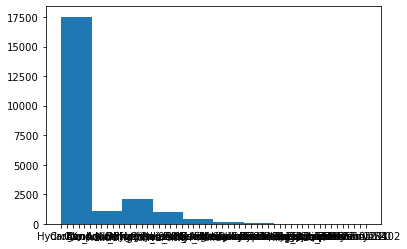

In [49]:
classes = []
for class_type in classes_filt:
        #class_type = class_type.lstrip("http://swrc.ontoware.org/ontology#")
        #class_type = class_type.lstrip("3.org/2002/07/owl#")
    class_type = class_type.lstrip("http://dl-learner.org/carcinogenesis#")
    class_type = class_type.lstrip("www.w3.org/2002/07/owl#")
    classes.append(class_type)
y = summarize_y(np.array(classes))
ax = plt.hist(y)
plt.show()

In [102]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

def compare_pred_nodimred(classifier=LogisticRegression):
    data = "mutag"
    num_embeddings = 3
    embeddings = []

    for iter in range(num_embeddings):
        embeddings.append(np.load("embeddings/" + data + "/embedding" + str(iter) + ".npy"))
    
    # some classifier for each embedding
    for j in range(num_embeddings):   
        X, y = select_data(embeddings[j])

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        if j==0:
            df_y = pd.DataFrame(data=y_test, columns=["truth"])
        
        
        
        #clf = DecisionTreeClassifier()
        #clf = LogisticRegression(C=0.5)
        #clf = MLPClassifier()
        clf = LinearSVC()
        clf.fit(X_train, y_train)
        
        scaler = StandardScaler()
        X_test = scaler.fit_transform(X_test)
        
        y_pred = clf.predict(X_test)
        # concatenate the columns
        df_y = pd.concat([df_y, pd.DataFrame(data=y_pred, columns=["Embedding" + str(j)])], axis=1)
        
        print(clf.predict(X_test[0:10]))
    # calculate the pairwise accuracy
    print(y_test[0:10])
    pw_accuracy = np.zeros((10,10))
    for j in range(num_embeddings):
        for i in range(num_embeddings):
            acc = sum( df_y["Embedding" + str(j)] == df_y["Embedding" + str(i)]) / len(df_y)  
            pw_accuracy[i, j] = np.round(acc, 2)
    pw_results = pw_accuracy[np.triu_indices(num_embeddings, k=1)]
    print(f'Results for the {data} dataset using RDF2Vec using {classifier} on the original 100-dim. data.')
    print(f'The average pairwise accuracy is {np.round(np.mean(pw_results), 2)} with a variance of {np.round(np.var(pw_results), 2)}.')

In [103]:
compare_pred_nodimred()

/home/mike/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


['Bond-1' 'Bond-1' 'Bond-1' 'Bond-1' 'Bond-1' 'Bond-1' 'Bond-1' 'Bond-1'
 'Bond-1' 'Bond-1']


/home/mike/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


['Bond-1' 'Bond-1' 'Bond-1' 'Hydrogen-3' 'Bond-1' 'Bond-1' 'Bond-1'
 'Bond-1' 'Bond-1' 'Bond-1']
['Bond-1' 'Bond-1' 'Bond-1' 'Bond-1' 'Bond-1' 'Bond-1' 'Bond-1' 'Bond-1'
 'Bond-1' 'Bond-1']
['Bond-1' 'Carbon-22' 'Carbon-22' 'Bond-1' 'Bond-7' 'Bond-7' 'Bond-1'
 'Bond-7' 'Bond-7' 'Bond-1']
Results for the mutag dataset using RDF2Vec using <class 'sklearn.linear_model._logistic.LogisticRegression'> on the original 100-dim. data.
The average pairwise accuracy is 0.95 with a variance of 0.0.


/home/mike/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
